In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from finta import TA
ticker = 'HDFCBANK.NS'  # Example: Apple Inc.
start_date = '2000-01-01'
end_date = '2024-12-31'

# Fetch the historical data
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
data['change'] = ((data['Close'] - data['Open'])/data['Open'])*100
data['change_shifted'] = data['change'].shift(-1)
data['class'] = np.where(data['change_shifted'] > 0.5, 1, 0)



[*********************100%%**********************]  1 of 1 completed


In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
ohlc = pd.DataFrame()
ohlc['open'] = data['Open']
ohlc['high'] = data['High']
ohlc['low'] = data['Low']
ohlc['close'] = data['Close'] 
ohlcv = pd.DataFrame()
ohlcv['open'] = data['Open']
ohlcv['high'] = data['High']
ohlcv['low'] = data['Low']
ohlcv['close'] = data['Close'] 
ohlcv['volume'] = data['Volume']

In [16]:
bbands = TA.BBANDS(ohlc)
ema = TA.EMA(ohlc)
rsi = TA.RSI(ohlc)
# stoch = TA.STOCHF(ohlc)
macd = TA.MACD(ohlc)
atr = TA.ATR(ohlc)
vwap = TA.VWAP(ohlcv)
obv = TA.OBV(ohlcv)
tsi = TA.TSI(ohlc)
mfi = TA.MFI(ohlcv)
kc = TA.KC(ohlc)
cci = TA.CCI(ohlc)
adx = TA.ADX(ohlc)
dmi = TA.DMI(ohlc)

df = data.copy()
df = pd.concat([df,bbands,ema,rsi,macd,atr,vwap,obv,tsi,mfi,kc,cci,adx,dmi],axis=1)

In [17]:
cutoff_date = '2000-02-21'
df_cut = df[df.index >= cutoff_date]
nan_count = df_cut.isna().sum()
nan_count

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
change             0
change_shifted     1
class              0
BB_UPPER           0
BB_MIDDLE          0
BB_LOWER           0
9 period EMA       0
14 period RSI      0
MACD               0
SIGNAL             0
14 period ATR      0
VWAP.              0
OBV               91
TSI                0
signal            11
14 period MFI      0
KC_UPPER           0
KC_LOWER           0
20 period CCI      0
14 period ADX.     0
DI+                0
DI-                0
dtype: int64

In [18]:
check = df_cut.drop('OBV' , axis=1)
check = check.drop('signal' , axis=1)
check = check.drop(check.index[-1])
check.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
change            0
change_shifted    0
class             0
BB_UPPER          0
BB_MIDDLE         0
BB_LOWER          0
9 period EMA      0
14 period RSI     0
MACD              0
SIGNAL            0
14 period ATR     0
VWAP.             0
TSI               0
14 period MFI     0
KC_UPPER          0
KC_LOWER          0
20 period CCI     0
14 period ADX.    0
DI+               0
DI-               0
dtype: int64

In [19]:
from sklearn.preprocessing import StandardScaler
x = check.drop(['change_shifted' , 'class'] , axis=1)
y = check['class']  
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42) 

### CNN Model

In [20]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Reshape data for CNN
X_train_reshaped = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(-1, X_test.shape[1], 1)

# Define the model
cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = cnn.evaluate(X_test_reshaped, y_test)
print("cnn accuracy:", accuracy)
# probabilities = model2.predict(X_test)
# print("Probabilities:\n", probabilities)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6615 - loss: 0.6433 - val_accuracy: 0.6706 - val_loss: 0.6375
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6745 - loss: 0.6326 - val_accuracy: 0.6706 - val_loss: 0.6422
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6834 - loss: 0.6224 - val_accuracy: 0.6697 - val_loss: 0.6272
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6886 - loss: 0.6153 - val_accuracy: 0.6697 - val_loss: 0.6284
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6690 - loss: 0.6304 - val_accuracy: 0.6706 - val_loss: 0.6297
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6755 - loss: 0.6235 - val_accuracy: 0.6697 - val_loss: 0.6368
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6712 - loss: 0.6245 - val_accuracy: 0.6733 - val_loss: 0.6315
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6766 - loss: 0.6235 - val_accuracy: 0.6706 - val_loss:

### MLP model

In [21]:
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
])
# Compile the model
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = mlp.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = mlp.evaluate(X_test, y_test)
print("MLP Accuracy:", accuracy)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5737 - loss: 0.7135 - val_accuracy: 0.6706 - val_loss: 0.6791
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6235 - loss: 0.6839 - val_accuracy: 0.6706 - val_loss: 0.6661
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6526 - loss: 0.6750 - val_accuracy: 0.6706 - val_loss: 0.6547
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6608 - loss: 0.6646 - val_accuracy: 0.6706 - val_loss: 0.6489
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6688 - loss: 0.6560 - val_accuracy: 0.6706 - val_loss: 0.6456
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6652 - loss: 0.6502 - val_accuracy: 0.6706 - val_loss: 0.6416
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6710 - loss: 0.6436 - val_accuracy: 0.6706 - val_loss: 0.6398
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6710 - loss: 0.6450 - val_accuracy: 0.6706 - val_loss:

### AUTOEncoder Model

In [22]:
ae = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
])
# Compile the model
ae.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = ae.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = ae.evaluate(X_test, y_test)
print("AutoEncoder Accuracy:", accuracy)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5866 - loss: 0.6935 - val_accuracy: 0.6706 - val_loss: 0.6600
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6706 - loss: 0.6531 - val_accuracy: 0.6706 - val_loss: 0.6529
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6743 - loss: 0.6511 - val_accuracy: 0.6706 - val_loss: 0.6477
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6646 - loss: 0.6431 - val_accuracy: 0.6706 - val_loss: 0.6375
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6777 - loss: 0.6363 - val_accuracy: 0.6706 - val_loss: 0.6370
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6784 - loss: 0.6336 - val_accuracy: 0.6706 - val_loss: 0.6361
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6658 - loss: 0.6442 - val_accuracy: 0.6706 - val_loss: 0.6358
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6880 - loss: 0.6276 - val_accuracy: 0.6706 - val_loss:

### BiLSTM Model

In [23]:
from tensorflow.keras.layers import LSTM, Bidirectional

# Define the model
bilstm = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1))),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Reshape data for LSTM
X_train_rnn = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_rnn = X_test.values.reshape(-1, X_test.shape[1], 1)

# Compile the model
bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
bilstm.fit(X_train_rnn, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = bilstm.evaluate(X_test_rnn, y_test)
print("BiLSTM Accuracy:", accuracy)

Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.6769 - loss: 0.6761 - val_accuracy: 0.6706 - val_loss: 0.6301
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6710 - loss: 0.6335 - val_accuracy: 0.6706 - val_loss: 0.6295
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6676 - loss: 0.6362 - val_accuracy: 0.6706 - val_loss: 0.6291
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.6965 - loss: 0.6148 - val_accuracy: 0.6706 - val_loss: 0.6314
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6712 - loss: 0.6325 - val_accuracy: 0.6706 - val_loss: 0.6298
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6586 - loss: 0.6409
BiLSTM Accuracy: 0.6743044257164001


### Results

In [26]:

def evaluate_model(model, X_test, y_test):
    """
    Evaluate a given model and plot confusion matrix and classification report.
    
    Parameters:
    model (object): Trained model to evaluate.
    X_test (array-like): Features for the test set.
    y_test (array-like): True labels for the test set.
    """
    # Predict probabilities
    probabilities = model.predict(X_test)
    
    # Filter probabilities lower than 0.20 or higher than 0.80
    filtered_indices = (probabilities < 0.20) | (probabilities > 0.80)
    filtered_probabilities = probabilities[filtered_indices]
    filtered_actuals = y_test[filtered_indices.flatten()]
    
    # Get predicted classes
    predicted_classes = (filtered_probabilities > 0.5).astype(int)
    
    # Create a DataFrame for actual vs. predicted
    results = pd.DataFrame({
        'Actual': filtered_actuals,
        'Predicted': predicted_classes.flatten(),
        'Probability': filtered_probabilities.flatten()
    })
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(filtered_actuals, predicted_classes)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    class_report = classification_report(filtered_actuals, predicted_classes, output_dict=True)
    
    # Convert the classification report to a DataFrame
    report_df = pd.DataFrame(class_report).transpose()
    
    # Plot the classification report
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Classification Report')
    plt.yticks(rotation=0)
    plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


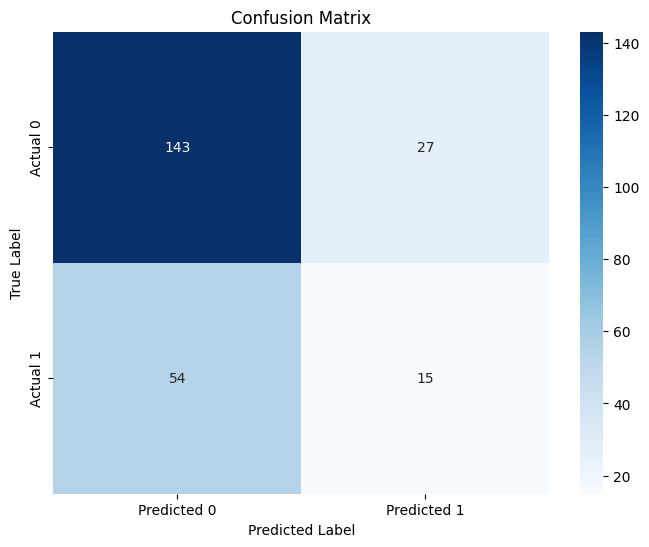

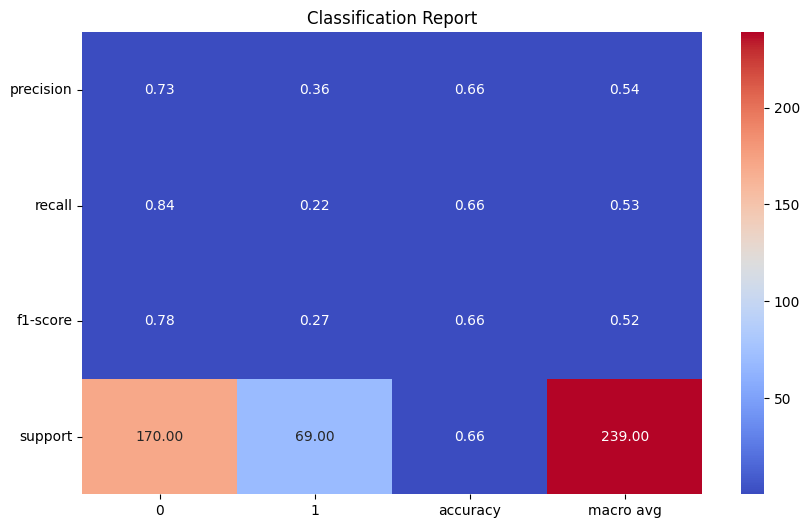

In [25]:
evaluate_model(cnn, X_test, y_test)